In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
from PIL import Image
import sys
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import copy as copy
from PIL import Image, ImageOps
sys.path.append("../")

from utils.hand_detector import get_hands_img
from models.models import CustomHeatmapsModel, EfficientWaterfall
from torchvision import transforms
from utils.utils import project_points_3D_to_2D, heatmaps_to_coordinates
from utils.testing import batch_epe_calculation,batch_auc_calculation,batch_pck_calculation, show_batch_predictions
from datasets.h2o import H2O_Dataset
import pandas as pd
import tqdm 
IMAGE_N = 193 # Index of image to see

from config import *

/caa/Homes01/wmucha/venvs/hands_keypoints/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [2]:
config = {  'device': 3,
            'data_dir': '/data/wmucha/datasets/h2o/h2o_CASA',
            "model_path": "/caa/Homes01/wmucha/repos/applied_deep_learning/applied_dl/waterfall_fulldata_scratch9_121",}

dataset = H2O_Dataset(config)

item = dataset[IMAGE_N]

img = item['image_raw']
cam_pose = item['cam_pose']
hand_pose = item['hand_pose']
hand_pose_mano = item['hand_pose_mano']
cam_instr = item['cam_instr']
img_name = item['img_name']
print(img_name)

/data/wmucha/datasets/h2o/h2o_CASA/subject6/s2/3/cam4/rgb/000091.png


In [3]:
hand_model = mp.solutions.hands.Hands()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


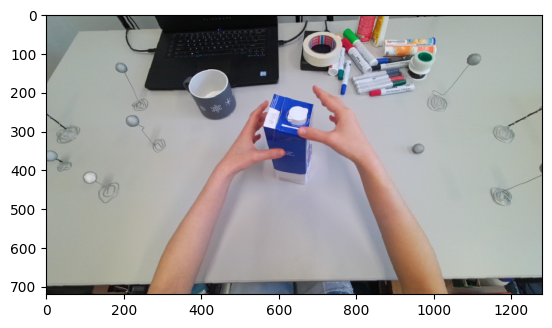

In [4]:
plt.imshow(img)
gt_pts= np.split(hand_pose,[1,64,65,128]) 


hand1 = np.reshape(gt_pts[1], (21,3))
hand2 = np.reshape(gt_pts[3], (21,3))
ptsL = project_points_3D_to_2D(hand1,cam_instr)
ptsP = project_points_3D_to_2D(hand2,cam_instr)

# for finger, params in COLORMAP.items():
#     plt.plot(
#         ptsL[params["ids"], 0],
#         ptsL[params["ids"], 1],
#         params["color"],
#         )

# for finger, params in COLORMAP.items():
#     plt.plot(
#         ptsP[params["ids"], 0],
#         ptsP[params["ids"], 1],
#         params["color"],
#         )

[{'index': 1, 'label': 'Left', 'x_min': 422, 'x_max': 649, 'y_min': 198, 'y_max': 425}, {'index': 0, 'label': 'Right', 'x_min': 622, 'x_max': 860, 'y_min': 162, 'y_max': 400}]
[{'index': 1, 'label': 'Left', 'x_min': 422, 'x_max': 649, 'y_min': 198, 'y_max': 425}, {'index': 0, 'label': 'Right', 'x_min': 622, 'x_max': 860, 'y_min': 162, 'y_max': 400}]


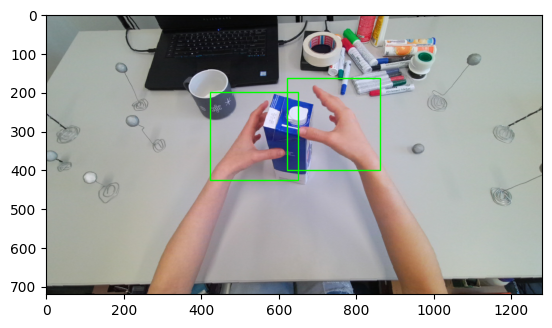

In [5]:
from matplotlib.patches import Rectangle

hands_dict = get_hands_img(img, hand_pose, cam_instr = cam_instr, hand_model=hand_model) 
bbs = hands_dict['hands_bb']
print(bbs)
plt.imshow(img)
print(bbs)
plt.gca().add_patch(Rectangle((int(bbs[0]['x_min']),int(bbs[0]['y_min'])),(bbs[0]['x_max']-bbs[0]['x_min']),(bbs[0]['y_max']-bbs[0]['y_min']),
                    angle=0,
                    edgecolor='lime',
                    facecolor='none',
                    lw=1))
plt.gca().add_patch(Rectangle((int(bbs[1]['x_min']),int(bbs[1]['y_min'])),(bbs[1]['x_max']-bbs[1]['x_min']),(bbs[1]['y_max']-bbs[1]['y_min']),
                    angle=0,
                    edgecolor='lime',
                    facecolor='none',
                    lw=1))



In [6]:
imgs = hands_dict['hands_seg']
gts = hands_dict['gt']
hand_label = hands_dict['hand_type']

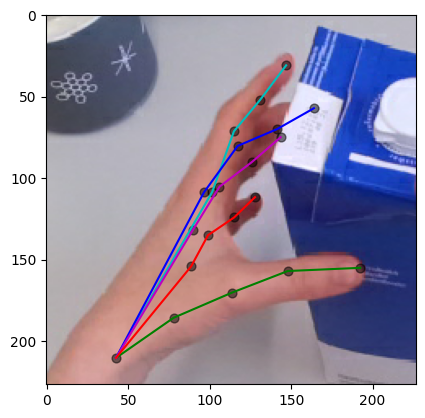

In [7]:
plt.imshow(imgs[0])
pts = gts[0] * imgs[0].size[0]
plt.scatter(pts[:, 0], pts[:, 1], c="k", alpha=0.5, s=40)
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )



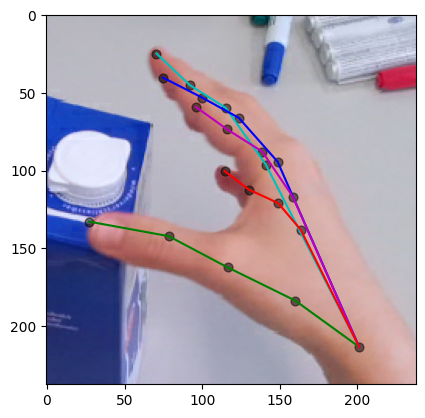

In [8]:
plt.imshow(imgs[1])
pts = gts[1] * imgs[1].size[0]
#TODO draw on image
plt.scatter(pts[:, 0], pts[:, 1], c="k", alpha=0.5, s=40)
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )



In [9]:
# model = CustomHeatmapsModel(3, 21)
model = EfficientWaterfall(N_KEYPOINTS)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

/caa/Homes01/wmucha/venvs/hands_keypoints/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded


In [10]:
imgs = hands_dict['hands_seg']
gts = hands_dict['gt']
hand_label = hands_dict['hand_type']

In [11]:

def run_model_on_hands(model, imgs, gts, hand_label):
    
    # imgs = hands_dict['hands_seg']
    # gts = hands_dict['gt']
    # hand_label = hands_dict['hand_type']
    
    # print(hands_dict)
    # apply normalization

    # print(type(imgs[0]))
    # print(type(imgs[1])    )
    transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS)
                ]
            )

    #transform first hand
    # if hand_label[0] == 'Left':
    #     print('flipping to right ', 0)
        # imgs[0] = np.flip(imgs[0], axis = 1)
    img0 = imgs[0]
    # else:
        #  gts[0] = np.flip(gts[0], axis = 1)
    # img0 = imgs[0]

    # if hand_label[1] == 'Left':
        # imgs[1] = np.flip(imgs[1], axis = 1)
    
    # img1 = ImageOps.mirror(imgs[1])
    # else:
    img1 = imgs[1]

    # plt.imshow(img1)
    
    img0 = transform(img0)
    img1 = transform(img1)

    flip = transforms.RandomHorizontalFlip(p=1)
    #transform second hand
    
    # if hand_label[1] == 'Left':
    #     imgs[1] = np.flip(imgs[1], axis = 1)
        # gts[1] = np.flip(gts[1], axis = 1)

    # inpt2 = transform(imgs[0])
    # if right
    # print(hand_label[0])
   
    inpt = torch.stack([img0,img1], dim=0)
   
    pred_heatmaps = model(inpt)
       
    # pred_heatmaps = pred_heatmaps.detach().numpy()
    
    # print(type(pred_heatmaps[0]))
    left = pred_heatmaps[0]

    right = pred_heatmaps[1]

    heatmaps = torch.stack([left,right], dim=0)
    # print(heatmaps.shape)

    # heatmaps = heatmaps
    pred_keypoints = heatmaps_to_coordinates(heatmaps.detach().numpy())

    # pred_keypoints[0] = np.flip(pred_keypoints[0], axis = 1)
    # pred_keypoints[0]

    return pred_keypoints



In [12]:

pred = run_model_on_hands(model, imgs, gts, hand_label)
print(hands_dict['hands_bb'])

[{'index': 1, 'label': 'Left', 'x_min': 422, 'x_max': 649, 'y_min': 198, 'y_max': 425}, {'index': 0, 'label': 'Right', 'x_min': 622, 'x_max': 860, 'y_min': 162, 'y_max': 400}]


In [13]:
def preds_to_full_image(predictions, hands_bb,scale):

    full_scale_preds = []

    pts = predictions[0] * scale[0]
    # print(len(pts))
    # print(pts.shape)
    # full_size_prediction

    # plt.imshow(ImageOps.mirror(imgs[0]))
    # plt.imshow((imgs[0]))
    # print(imgs[0].size[0])
    # pts = pred[0] * imgs[0].size[0]
    #TODO draw on image

    # pts[:,0] += hands_bb[0]['x_min']
    # pts[:,1] += hands_bb[0]['y_min']
    pts[:,0] = pts[:,0] + hands_bb[0]['x_min']
    pts[:,1] = pts[:,1] + hands_bb[0]['y_min']

    # print(pts)
    full_scale_preds.append(pts)
    # for finger, params in COLORMAP.items():
    #     plt.plot(
    #         pts[params["ids"], 0],
    #         pts[params["ids"], 1],
    #         params["color"],
    #         )


    pts = predictions[1] * scale[1]
    pts[:,0] += hands_bb[1]['x_min']
    pts[:,1] += hands_bb[1]['y_min']
    full_scale_preds.append(pts)
    # for finger, params in COLORMAP.items():
    #     plt.plot(
    #         pts[params["ids"], 0],
    #         pts[params["ids"], 1],
    #         params["color"],
    #         )

   
    # plt.imshow(img)
    # print(img.size)
    return full_scale_preds

In [14]:
scale = [imgs[0].size[0], imgs[1].size[0]]

full_scale_preds = preds_to_full_image(predictions = pred, hands_bb = hands_dict['hands_bb'], scale = scale)

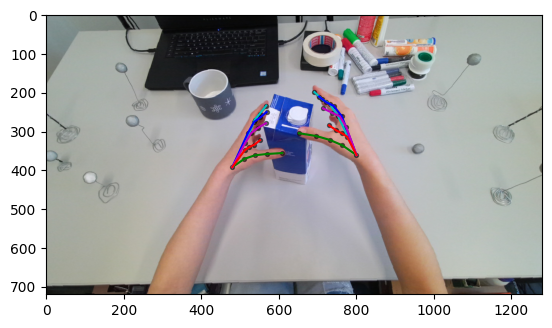

In [15]:
pts = full_scale_preds[0]
plt.scatter(pts[:, 0], pts[:, 1], c="k", alpha=0.5, s=8)
for finger, params in COLORMAP.items():
        plt.plot(
            pts[params["ids"], 0],
            pts[params["ids"], 1],
            params["color"],
            )


    # pts = predictions[1] * scale[1]
    # pts[:,0] += hands_bb[1]['x_min']
    # pts[:,1] += hands_bb[1]['y_min']

pts = full_scale_preds[1]
plt.scatter(pts[:, 0], pts[:, 1], c="k", alpha=0.5, s=8)
for finger, params in COLORMAP.items():
        plt.plot(
            pts[params["ids"], 0],
            pts[params["ids"], 1],
            params["color"],
            )

   
plt.imshow(img)

227


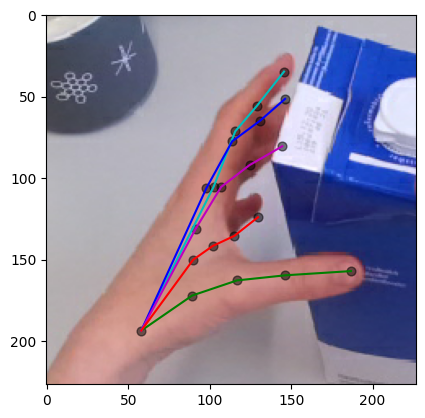

In [16]:
plt.imshow(ImageOps.mirror(imgs[0]))
plt.imshow((imgs[0]))
print(imgs[0].size[0])



pts = pred[0] * imgs[0].size[0]
plt.scatter(pts[:, 0], pts[:, 1], c="k", alpha=0.5, s=40)
#TODO draw on image
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )



In [17]:
def flip_img(img: np):
    
    return np.flip(img, axis = 1) 


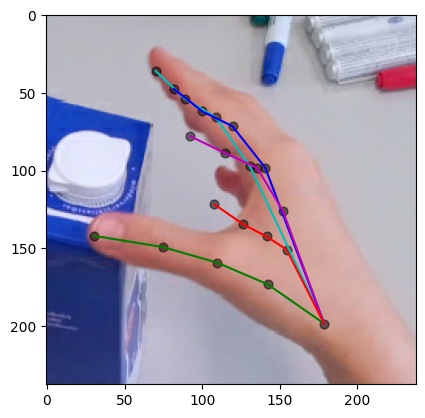

In [18]:
plt.imshow((imgs[1]))
# print(imgs[1].size)



pts = pred[1] * imgs[1].size[0]
plt.scatter(pts[:, 0], pts[:, 1], c="k", alpha=0.5, s=40)
for finger, params in COLORMAP.items():
    plt.plot(
        pts[params["ids"], 0],
        pts[params["ids"], 1],
        params["color"],
        )

In [19]:
def get_testing_images(data_dir):

    image_dir = os.path.join(data_dir, "subject1",'h1','1','cam4','rgb')
        # print(image_dir)
    image_names = np.sort(os.listdir(image_dir))
            # print(image_names)
    temp_rgbpaths = []
    for img_name in image_names:
        temp_rgbpaths.append(os.path.join(image_dir, img_name))
            # img_paths = os.path.join(image_dir, image_names)
            # print(temp_paths)

            # temp_campose_dir = os.path.join(config["data_dir"], "subject1",'h1','1','cam4','cam_pose')
    temp_cam_pose = []
    for cam_pose in temp_rgbpaths:
        temp_cam_pose.append(cam_pose.replace('rgb', 'cam_pose').replace('.png','.txt'))

    temp_hand_pose = []
    for hand_pose in temp_rgbpaths:
        temp_hand_pose.append(hand_pose.replace('rgb', 'hand_pose').replace('.png','.txt'))

    temp_hand_pose_mano = []
    for hand_pose_mano in temp_rgbpaths:
        temp_hand_pose_mano.append(hand_pose_mano.replace('rgb', 'hand_pose_mano').replace('.png','.txt'))

    temp_cam_instr = []
    for cam_instr in temp_rgbpaths:
        temp_cam_instr.append(os.path.join(config["data_dir"], "subject1",'h1','1','cam4','cam_intrinsics.txt'))


            
    img_paths = np.asarray(temp_rgbpaths)
    cam_pose = np.asarray(temp_cam_pose)
    hand_pose = np.asarray(temp_hand_pose)
    hand_pose_mano = np.asarray(temp_hand_pose_mano)
    cam_instr = np.asarray(temp_cam_instr)

    return {
        'img_paths': img_paths,
        'cam_pose': cam_pose,
        'hand_pose': hand_pose,
        'cam_instr': cam_instr
    }

In [20]:
data_set = get_testing_images(config['data_dir'])

In [21]:
def get_instr(arr):
    cam = np.zeros((3,3))
    cam[0][0] = arr[0]
    cam[0][2] = arr[2]
    cam[1][1] = arr[1]
    cam[1][2] = arr[3]
    cam[2][2] = 1
    
    return cam

In [22]:
img_paths = data_set['img_paths']

cam_instr_paths = data_set['cam_instr']
hand_pose_paths = data_set['hand_pose']

# hand_pose = np.loadtxt(hand_pose[0])

# cam_instr = get_instr(np.loadtxt(cam_instr[0]))
# print(cam_instr)

In [23]:
pck_acc = []
epe_lst = []
auc_lst = []

for idx in range(len(img_paths)):
    img = Image.open(img_paths[idx])
    # print(hand_pose)
    hand_pose = np.loadtxt(hand_pose_paths[idx])
    cam_instr = get_instr(np.loadtxt(cam_instr_paths[idx]))

    # print(hand_pose)
    # print(cam_instr)
    hands_dict = get_hands_img(img, hand_pose, cam_instr = cam_instr, hand_model=hand_model) 

    imgs = hands_dict['hands_seg']
    gts = hands_dict['gt']
    hand_label = hands_dict['hand_type']

    pred = run_model_on_hands(model, imgs, gts, hand_label)
    
    gts0 = np.reshape(gts[0],(1,21,2))
    gts1 = np.reshape(gts[1],(1,21,2))
    gt_keyboards = np.concatenate((gts0,gts1))
    # print(gt_keyboards)
    # print(pred)


    avg_acc = batch_pck_calculation(pred, gt_keyboards, treshold = 0.2, mask = None, normalize = None)
    pck_acc.append(avg_acc)

    # Calculate EPE mean and median, mind that it depends on what scale of input keypoints 
    epe = batch_epe_calculation(pred, gt_keyboards)
    epe_lst.append(epe)

    # AUC calculation
    auc = batch_auc_calculation(pred, gt_keyboards, num_step=20, mask = None)
    auc_lst.append(auc)

    plt.imshow(ImageOps.mirror(imgs[0]))
    plt.imshow((imgs[0]))
    break


IndexError: list index out of range

In [ ]:
pck_acc = []
epe_lst = []
auc_lst = []

for idx in range(50,52):
    print(idx)
    item = dataset[idx]
    
    img = item['image_raw']
    # cam_pose = item['cam_pose']
    hand_pose = item['hand_pose']
    # hand_pose_mano = item['hand_pose_mano']
    cam_instr = item['cam_instr']

    hands_dict = get_hands_img(img, hand_pose, cam_instr = cam_instr, hand_model=hand_model) 
    
    imgs = hands_dict['hands_seg']
    gts = hands_dict['gt']
    hand_label = hands_dict['hand_type']

    pred = run_model_on_hands(model, imgs, gts, hand_label)
    
    gts0 = np.reshape(gts[0],(1,21,2))
    gts1 = np.reshape(gts[1],(1,21,2))
    gt_keyboards = np.concatenate((gts0,gts1))
    # print(gt_keyboards)
    # print(pred)


    avg_acc = batch_pck_calculation(pred, gt_keyboards, treshold = 0.2, mask = None, normalize = None)
    pck_acc.append(avg_acc)

    # Calculate EPE mean and median, mind that it depends on what scale of input keypoints 
    epe = batch_epe_calculation(pred, gt_keyboards)
    epe_lst.append(epe)

    # AUC calculation
    auc = batch_auc_calculation(pred, gt_keyboards, num_step=20, mask = None)
    auc_lst.append(auc)

    plt.imshow(ImageOps.mirror(imgs[0]))
    plt.imshow((imgs[0]))
    # print(imgs[0].size[0])
    # pts = pred[0] * imgs[0].size[0]
    # #TODO draw on image
    # for finger, params in COLORMAP.items():
    #     plt.plot(
    #         pts[params["ids"], 0],
    #         pts[params["ids"], 1],
    #         params["color"],
    #         )
            
    # break
pck = sum(pck_acc) / len(pck_acc)
epe_final = sum(epe_lst) / len(epe_lst)
auc_final = sum(auc_lst) / len(auc_lst)

print (f'PCK@2: {pck}, EPE: {epe_final}, AUC: {auc_final}')